In [ ]:
import numpy as np
import pandas as pd
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

In [ ]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    #Builds a new DataFrame to facilitate regressing over all possible lagged features'''
    if type(s) is pd.DataFrame:
        new_dict={}
        for l in range(lag,0,-1):
            #new_dict[col_name]=s[col_name]
            # create lagged Series
            for col_name in s:
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        for col_name in s:
            new_dict[col_name]=s[col_name]
        res=pd.DataFrame(new_dict,index=s.index)
        #print(res.head())

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [ ]:
def create_data(scaler2,data,lag):
    #o_data = read_csv('NLIC_stock.csv', header=0)
    #data['Date'] = pd.to_datetime(o_data['Date'])
    #mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2018-12-30')
    #t_data=data.loc[mask]
    t_data= data.drop(columns=['Symbol'])
    t_data.set_index(['Date'], inplace=True)
    t_data=t_data.drop(columns=['Open','High','Vol','Low'])
    t_data['Close'] = scaler2.transform((t_data['Close'].to_numpy()).reshape(-1,1))
    #print(t_data.head())
    res=buildLaggedFeatures(t_data,lag,dropna=True)
    #print(res.head())
    res=res.drop(columns=['Close'])
    
    return res  

In [ ]:
def create_yvalues(scaler2,df,lead):
    dataY = []
    df['Close'] = scaler2.transform((df['Close'].to_numpy()).reshape(-1,1))
    #print(df.head())
    for i in range(len(df)-lead):
        dataY.append(df[i:(i+lead)])
    return np.array(dataY)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/EBL_stock.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'])
mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2018-12-31')
t_data=data.loc[mask]
#print(t_data.head())
scaler2=MinMaxScaler()
x_sample = [60, 3000]
scaler2.fit(np.array(x_sample)[:, np.newaxis])
lag=8
prediction_days=6
trainX= create_data(scaler2,t_data,lag)
tY= data[lag:len(trainX)+prediction_days+lag]
t_y=pd.DataFrame(tY['Close'])
#print(t_y.head())
#print(len(trainX),len(trainY))
trainY=create_yvalues(scaler2,t_y,prediction_days)
trainY=trainY.transpose(2,0,1).reshape(-1,trainY.shape[1])
print(trainY)
trainY=pd.DataFrame(trainY)
#print(trainX.head())


print(trainY.head())
print(trainY.shape)

#print(trainX.head(),trainY.head(5))
#print(trainX.shape)



[[0.22244898 0.22721088 0.21530612 0.21666667 0.21530612 0.21326531]
 [0.22721088 0.21530612 0.21666667 0.21530612 0.21326531 0.21258503]
 [0.21530612 0.21666667 0.21530612 0.21326531 0.21258503 0.20748299]
 ...
 [0.16666667 0.16598639 0.16326531 0.16258503 0.16326531 0.16156463]
 [0.16598639 0.16326531 0.16258503 0.16326531 0.16156463 0.16054422]
 [0.16326531 0.16258503 0.16326531 0.16156463 0.16054422 0.16054422]]
          0         1         2         3         4         5
0  0.222449  0.227211  0.215306  0.216667  0.215306  0.213265
1  0.227211  0.215306  0.216667  0.215306  0.213265  0.212585
2  0.215306  0.216667  0.215306  0.213265  0.212585  0.207483
3  0.216667  0.215306  0.213265  0.212585  0.207483  0.211565
4  0.215306  0.213265  0.212585  0.207483  0.211565  0.214286
(1608, 6)


In [ ]:

train_x = trainX.values
# split into train and test sets

#print(Q.tail())
#q=scaler2.fit_transform(Q.values)

#print(c)
train_y=trainY.values
train_x=np.array(train_x)
train_y=np.array(train_y)

#print(c[1512-12:])
#print(train_y[1512-12:])
#create effective data structure for training
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
train_y =np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))
print(len(train_x),len(train_y),train_x.shape,train_y.shape)

1608 1608 (1608, 8, 1) (1608, 6, 1)


In [ ]:
#we create model using 1D CNN and use repeat vector of 7 days to create a model that can effectively predict 7 days ahead values
#Time Distributed layer help to even time relationship amog input values
# the concept is CNN extract features, LSTM develops Relationship among features, 
#and time distributed layer helps too develop time relationship among indermidiate outputs
batch_size = 32
opt=Adam(
    learning_rate=0.0015,
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-07,
    amsgrad=True,
    )
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(lag,1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(prediction_days))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=opt)

In [ ]:
%%time
history=model.fit(train_x, train_y, epochs=150, batch_size=batch_size, shuffle=False)

Epoch 1/150
51/51 [==============================] - 3s 6ms/step - loss: 0.0498
Epoch 2/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 3/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 4/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 6/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 7/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0480
Epoch 8/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 9/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0743
Epoch 10/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0745
Epoch 11/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0776
Epoch 12/150
51/51 [==============================] - 0s 5ms/step - loss: 0.0776
Epoch 13/150
51/51 [=================

In [ ]:
def get_prediction(y,scaler2):
  Out=model.predict(y,verbose=0)
  #print(Out)
  Out=Out.reshape(1,-1)
  
  Out=Out.reshape(-1,1)
  Out=  scaler2.inverse_transform(Out)
  output_7=pd.DataFrame(Out)  
  return output_7


In [ ]:
predict_after="2019-8-21"
Y=data.copy
test_data=data.loc[data['Date'] < predict_after].tail(lag+1)
print(test_data)
output_test_data=data.loc[data['Date'] >= predict_after].head(prediction_days)
output_test_data.set_index(['Date'],inplace=True)
output_test_close=output_test_data['Close']
X=create_data(scaler2,test_data,lag)
X=X.values
#X=scaler1.transform(X.values)
X = np.reshape(X, (1,X.shape[1], X.shape[0]))
model_output=get_prediction(X,scaler2)
model_output.set_index(output_test_close.index,inplace=True)
model_output.rename(columns={0:'Close'},inplace=True)
output_test_close=pd.DataFrame(output_test_close)
print(model_output)
print(output_test_close)



     Symbol       Date  Open  High  Low  Close    Vol
1766    EBL 2019-08-08   664   664  651    653  4,380
1767    EBL 2019-08-11   650   667  650    667  9,429
1768    EBL 2019-08-12   665   665  654    657  5,983
1769    EBL 2019-08-13   657   657  653    655  8,123
1770    EBL 2019-08-14   650   655  647    647  3,884
1771    EBL 2019-08-15   648   648  641    641  2,293
1772    EBL 2019-08-18   645   661  641    642  8,553
1773    EBL 2019-08-19   642   658  642    651  7,588
1774    EBL 2019-08-20   651   653  647    650  3,043
                 Close
Date                  
2019-08-21  632.893677
2019-08-22  636.578735
2019-08-25  641.913208
2019-08-26  633.530457
2019-08-27  639.238525
2019-08-28  633.384094
            Close
Date             
2019-08-21    651
2019-08-22    649
2019-08-25    655
2019-08-26    648
2019-08-27    650
2019-08-28    644


In [ ]:
#calculate RMSE
def error(X,Y):
    Close_error= ((X['Close'] - Y['Close']) ** 2).mean() ** .5
    print("Close_error =",Close_error)

In [ ]:
error(output_test_close,model_output)

Close_error = 16.39004366706765


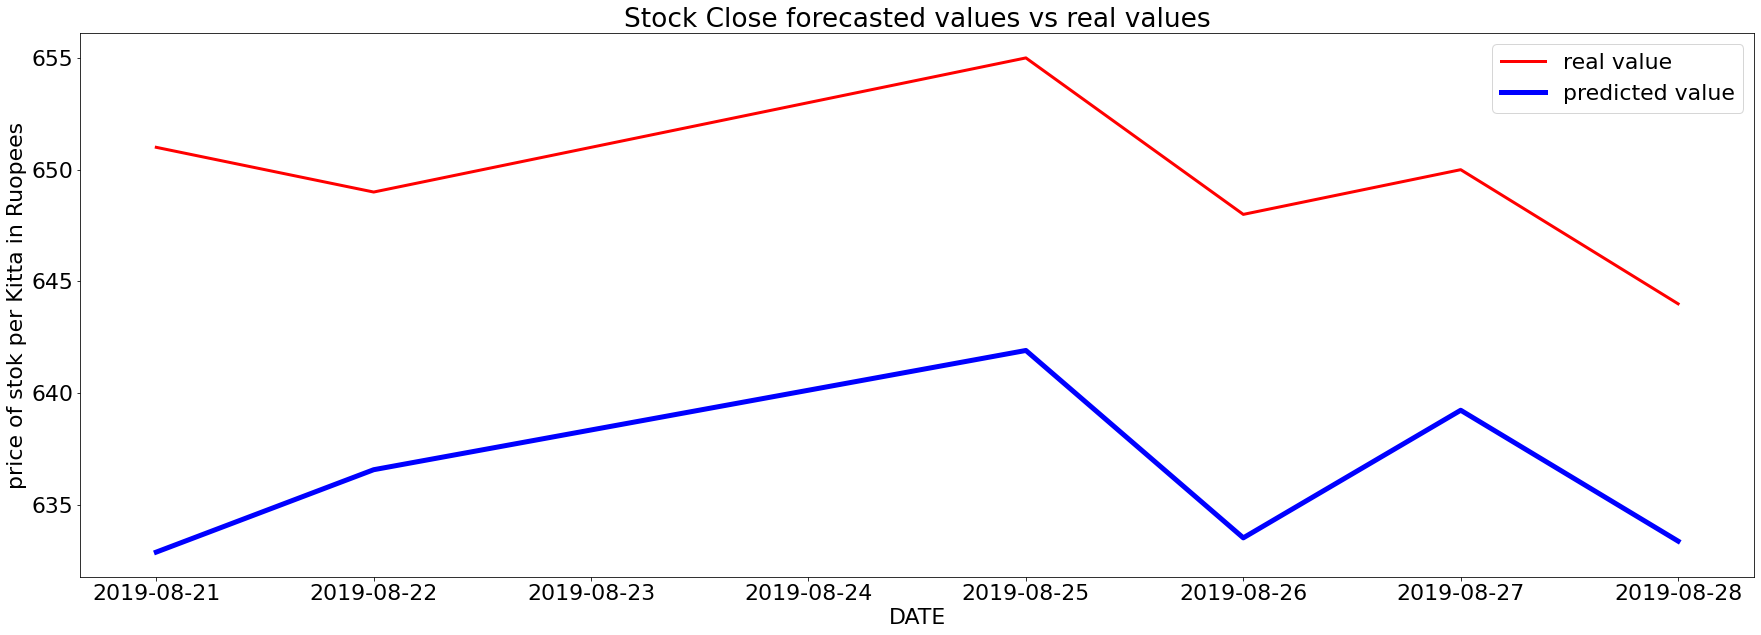

In [ ]:
real= output_test_close
predicted= model_output
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.plot(real, color = 'red',linewidth=3, label = 'real value')
plt.plot(predicted, color = 'blue', linewidth=5,label = 'predicted value')
plt.title('Stock Close forecasted values vs real values')
plt.xlabel('DATE')
plt.ylabel('price of stok per Kitta in Ruopees')
plt.legend()
plt.show()